In [9]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from definitions import get_cell_phenotype_id

In [10]:
INPUT_Reference = os.path.join(
    PROJECT_ROOT, "Output", "a_Cellular_graph_random_split", "Danenberg", "Subset_1"
)
INPUT_Query = os.path.join(PROJECT_ROOT, "Output", "a_Cellular_graph_random_split", "Jackson")
OUTPUT_ROOT = os.path.join(PROJECT_ROOT, "Output", "a_Cellular_graph_random_split", "Jackson")
FILE_NAMES_Reference = os.listdir(INPUT_Reference)
FILE_NAMES_Query = os.listdir(INPUT_Query)

In [11]:
X_Reference = []
Label_Reference = []
for i in range(len(FILE_NAMES_Reference)):
    file_name = FILE_NAMES_Reference[i]
    patient_id = int(file_name.split("_")[1])
    X = np.load(
        os.path.join(
            INPUT_Reference,
            file_name,
            "ProteinExpression.npy",
        )
    )
    Label = np.load(
        os.path.join(
            INPUT_Reference,
            file_name,
            "CellType.npy",
        )
    )
    X_Reference.append(X)
    Label_Reference.append(Label)
X_Reference = np.concatenate(X_Reference, axis=0)
Label_Reference = np.concatenate(Label_Reference, axis=0)

X_Query = []
Label_Query = []
Label_Query_alignment = []
for i in range(len(FILE_NAMES_Query)):
    file_name = FILE_NAMES_Query[i]
    patient_id = int(file_name.split("_")[1])
    X = np.load(
        os.path.join(
            INPUT_Query,
            file_name,
            "ProteinExpression.npy",
        )
    )
    Label = np.load(
        os.path.join(
            INPUT_Query,
            file_name,
            "CellType.npy",
        )
    )
    Label_alignment = np.load(
        os.path.join(
            INPUT_Query,
            file_name,
            "matched_CellType_centroid_alignment.npy",
        )
    )
    X_Query.append(X)
    Label_Query.append(Label)
    Label_Query_alignment.append(Label_alignment)
X_Query = np.concatenate(X_Query, axis=0)
Label_Query = np.concatenate(Label_Query, axis=0)
Label_Query_alignment = np.concatenate(Label_Query_alignment, axis=0)
print(X_Reference.shape, Label_Reference.shape)
print(X_Query.shape, Label_Query.shape, Label_Query_alignment.shape)

(670335, 17) (670335,)
(762616, 17) (762616,) (762616, 1)


### Jackson original cell type v.s. matched cell type

In [12]:
def reverse_dict(dictionary):
    wrapped_dict = {}
    for key, value in dictionary.items():
        wrapped_dict[value] = key
    return wrapped_dict

In [13]:
DF_Jackson = pd.DataFrame({
    'cell_type_original': list(Label_Query.reshape(-1)),
    'cell_type_aligned': list(Label_Query_alignment.reshape(-1)),
})
DF_Jackson['cell_type_original'] = DF_Jackson['cell_type_original'].map(

        reverse_dict(get_cell_phenotype_id('Jackson'))

)
DF_Jackson['cell_type_aligned'] = DF_Jackson['cell_type_aligned'].map(
    
        reverse_dict(get_cell_phenotype_id('Danenberg'))
)
DF_Jackson.head(20)

,cell_type_original,cell_type_aligned
0,CK low HR low,CK^{+} CXCL12^{+}
1,CK low HR low,CK^{lo}ER^{lo}
2,CK low HR low,Ep CD57^{+}
3,CK low HR low,Fibroblasts
4,CK low HR low,Granulocytes
5,CK low HR low,CK^{lo}ER^{med}
6,CK low HR low,CK^{lo}ER^{med}
7,Macrophages_1,CD4^{+} T cells & APCs
8,CK low HR low,CK^{+} CXCL12^{+}
9,Macrophages_1,Granulocytes


In [14]:
Matching_heatmap = np.zeros((len(np.unique(Label_Query)), len(np.unique(Label_Query_alignment))))
for i in range(len(np.unique(Label_Query))):
    for j in range(len(np.unique(Label_Query_alignment))):
        a = list(np.where(Label_Query == i)[0])
        b = list(np.where(Label_Query_alignment == j)[0])
        IoU = len(set(a).intersection(set(b))) / len(set(a).union(set(b)))
        Matching_heatmap[i, j] = IoU

[Text(0.5, 20.736689814814746, 'Aligned Cell type'),
 Text(45.45659722222221, 0.5, 'Original cell type'),
 Text(0.5, 1.0, 'IoU of cell type alignment')]

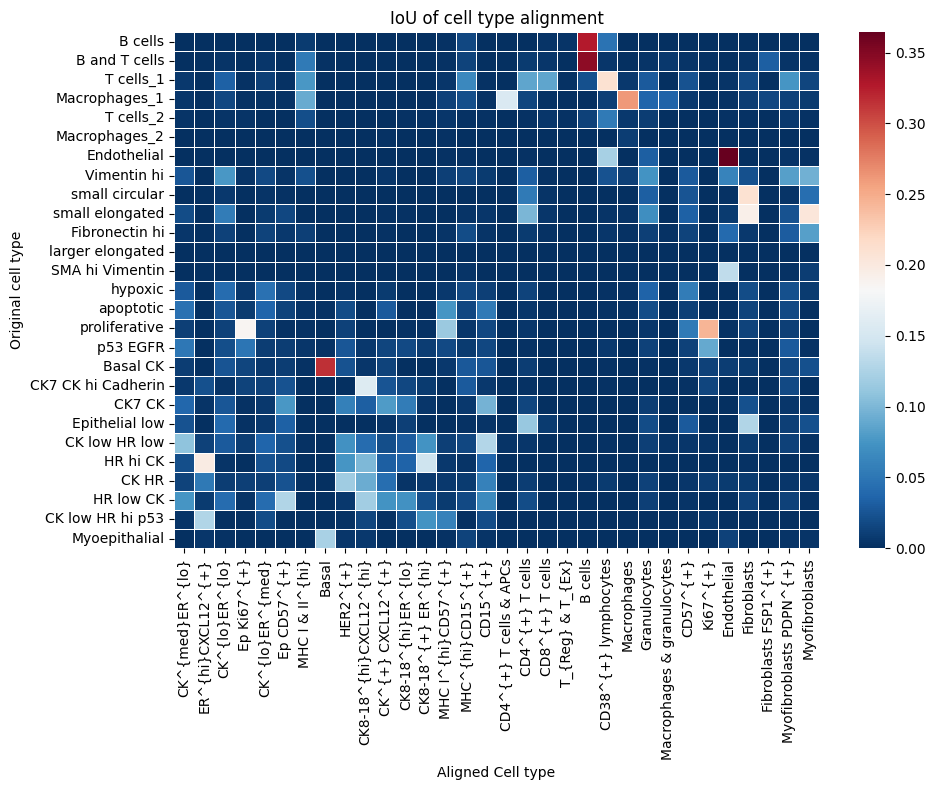

In [16]:
Cell_types_original = list(map(reverse_dict(get_cell_phenotype_id("Jackson")).get, range(np.unique(Label_Query).shape[0])))
Cell_types_aligned = list(map(reverse_dict(get_cell_phenotype_id("Danenberg")).get, range(np.unique(Label_Query_alignment).shape[0])))
f, ax = plt.subplots(figsize=(10, 8), tight_layout=True)
sns.heatmap(
    Matching_heatmap,
    ax=ax,
    xticklabels=Cell_types_aligned,
    yticklabels=Cell_types_original,
    cmap="RdBu_r",
    vmin=0,
    # vmax=0.3,
    linewidths=0.5,
)
ax.set(
    xlabel="Aligned Cell type",
    ylabel="Original cell type",
    title="IoU of cell type alignment",
)